In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from PIL import Image
import cv2
from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.nuscenes import NuScenes

from torch import nn


In [9]:
import torchvision.transforms as T

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

denormalize_img = T.Compose([
    T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std],
    ),
    T.Lambda(lambda x: x.clamp(0, 1)),  
    T.ToPILImage(),
])

normalize_img = T.Compose([
    T.ToTensor(),                      
    T.Normalize(mean=mean, std=std),
])

In [ ]:


nusc = NuScenes(version='v1.0-mini', dataroot='/home/ap/dataset/nuscenes', verbose=True)

last_sample_token = '63c24b51feb94f14bec29022dae4975d'
second_last_sample_token  = 'de9432d4fc7a4e5a985e2bc628eb614c'
last_sample = nusc.get('sample', last_sample_token)
second_last_sample = nusc.get('sample', second_last_sample_token)
samples = [second_last_sample, last_sample]

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.599 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
cams = ['CAM_FRONT_LEFT','CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

input_image_height = 128
input_image_width = 352

images_per_batch = []
rotations_per_batch = []
translations_per_batch = []
intrinsics_per_batch = []
resize_transforms_per_batch = []
crop_transforms_per_batch = []
gt_binary_images_per_batch = []

for my_sample in samples:
    images = []
    rotations = []
    translations = []
    intrinsics = []
    resize_transforms = []
    crop_transforms = []
    for cam in cams:
        cam_data = nusc.get('sample_data', my_sample['data'][cam])
        image_name = os.path.join(nusc.dataroot, cam_data['filename'])
        img  = Image.open(image_name)
        # print(f"Image from {cam}: size {img.size}")

        calibrated_sensor_token = cam_data['calibrated_sensor_token']
        calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
        rotation = torch.tensor(Quaternion(calibrated_sensor['rotation']).rotation_matrix)
        translation = torch.tensor(calibrated_sensor['translation'])
        camera_intrinsic = torch.tensor(calibrated_sensor['camera_intrinsic'])
        H,W = img.size[1], img.size[0]
        # print(f"Rotation:\n{rotation}\nTranslation:\n{translation}\nIntrinsics:\n{camera_intrinsic}\nImage Height: {H}, Width: {W}\n")
        # print("=============================================================================================================================================")

        resize = max(input_image_height / H, input_image_width / W) #this is to maintain aspect ratio
        resize_dims = (int(W * resize), int(H * resize))
        # print(f"Resize dimensions to fit feature map: {resize_dims}\n\n")
        newW, newH = resize_dims
        # cropping from the top since the top usually has more irrelevant info (sky) 
        # in the orginal implementation, cropping is done from bottom + top randomly with more weight on top
        crop_h = newH - input_image_height
        crop_w = newW - input_image_width
        crop = (crop_w, crop_h, crop_w + input_image_width, crop_h + input_image_height)
        # print(f"Crop box to get feature map size: {crop}\n")

        img = img.resize(resize_dims).crop(crop)
        #post homography transformations,
        # we can consider resize and crop as two homography transformations and need to make matrices for them, because we want to undo later during projection because the intrinscs
        # and extrinsics are for original image size and this needs to be taken care
        # ideally these two should be two dimensional but now making it 3 work numerically well so
        # for resize transform for z we multiply by 1, which is a no change and for crop_transform for z we subtract 0 which is also a no change. 
        resize_transform = torch.diag(torch.tensor([resize,resize, 1.0])) 
        crop_transform   = -torch.tensor([[crop_w,crop_h,0.0]])

        # print(f"Resize transform:\n{resize_transform}")
        # print(f"Crop transform:\n{crop_transform}")

        images.append(normalize_img(img))
        rotations.append(rotation)
        translations.append(translation)
        intrinsics.append(camera_intrinsic)
        resize_transforms.append(resize_transform)
        crop_transforms.append(crop_transform)

    images_per_batch.append(torch.stack(images))
    rotations_per_batch.append(torch.stack(rotations))  
    translations_per_batch.append(torch.stack(translations))
    intrinsics_per_batch.append(torch.stack(intrinsics))
    resize_transforms_per_batch.append(torch.stack(resize_transforms))
    crop_transforms_per_batch.append(torch.stack(crop_transforms))
    


    sd_lidar = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    # get ego pose to transform from global to ego vehicle frame
    egopose = nusc.get('ego_pose', sd_lidar['ego_pose_token'])
    trans = -np.array(egopose['translation'])
    rot = Quaternion(egopose['rotation']).inverse

    nx = np.array([200, 200,1]) 
    bx = np.array([-49.75, -49.75, -3.0])
    dx = np.array([0.5, 0.5, 20.0])

    target_binary_image = np.zeros((nx[0], nx[1]))
    for tok in my_sample['anns']:
        inst = nusc.get('sample_annotation', tok)
        # add category for lyft
        if not inst['category_name'].split('.')[0] == 'vehicle':
            continue
        box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
        # bring box to ego frame
        box.translate(trans)
        box.rotate(rot)

        pts = box.bottom_corners()[:2].T
        # bring points to grid coords
        pts = np.round(
            (pts - bx[:2] + dx[:2]/2.) / dx[:2]
            ).astype(np.int32)
        pts[:, [1, 0]] = pts[:, [0, 1]]
        cv2.fillPoly(target_binary_image, [pts], 1.0)
    gt_binary_images_per_batch.append(torch.tensor(target_binary_image))



#Saving the data for  the data for tutorial usage
data = {"images":torch.stack(images_per_batch),  # (B, num_cams, 3, H, W)
        "rotations":torch.stack(rotations_per_batch),  # (B, num_cams, 3, 3)
        "translations":torch.stack(translations_per_batch),  # (B, num_cams, 3)
        "intrinsics":torch.stack(intrinsics_per_batch),  # (B, num_cams, 3, 3),
        "resize_transforms":torch.stack(resize_transforms_per_batch),  # (B, num_cams, 3, 3)
        "crop_transforms":torch.stack(crop_transforms_per_batch),  # (B, num_cams, 1, 3)
        "gt_binary_images":torch.stack(gt_binary_images_per_batch)  # (B, H, W)
        }
# data = torch.save(data,"nuscenes_mini_sample_data_batch.pt")


In [26]:
import torch
import torch.nn as nn
import timm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F
%matplotlib inline

In [ ]:
cams  = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
data = torch.load("nuscenes_mini_sample_data_batch.pt")

nx = np.array([200, 200,1]) 
bx = np.array([-49.75, -49.75, -3.0])
dx = np.array([0.5, 0.5, 20.0])

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

denormalize_img = T.Compose([
    T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std],
    ),
    T.Lambda(lambda x: x.clamp(0, 1)),  
    T.ToPILImage(),
])

normalize_img = T.Compose([
    T.ToTensor(),                      
    T.Normalize(mean=mean, std=std),
])

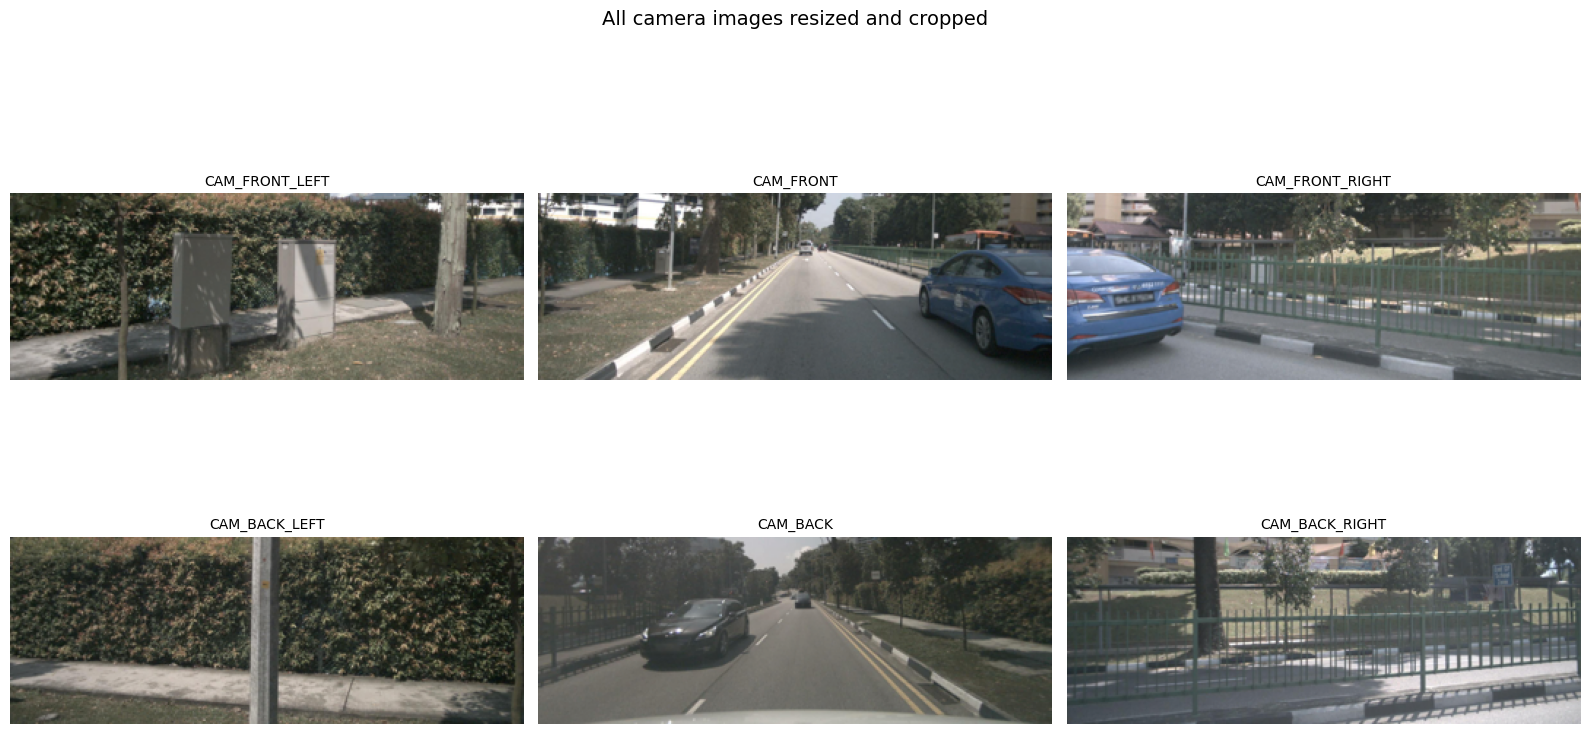

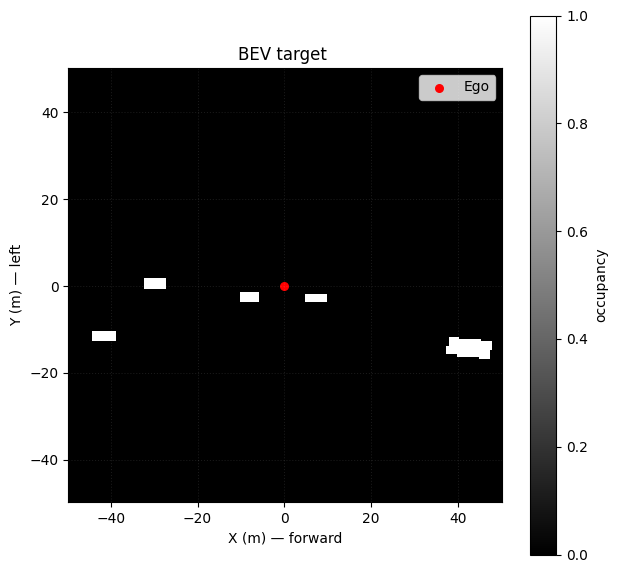

In [19]:
images, rotations, translations, intrinsics, resize_transforms, crop_transforms, target_binary_image = (
    data['images'],
    data['rotations'],
    data['translations'],
    data['intrinsics'],
    data['resize_transforms'],
    data['crop_transforms'],
    data['gt_binary_images']
)


def plot_all_cams(images_batch, cams):
    imgs = images_batch  # tensor [6, C, H, W] or [6, H, W, C]
    n = len(cams)
    rows, cols = 2, 3
    plt.figure(figsize=(16, 9))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img = denormalize_img(imgs[i])
        plt.imshow(img)
        plt.title(cams[i], fontsize=10)
        plt.axis('off')
    plt.suptitle('All camera images resized and cropped', fontsize=14)
    plt.tight_layout()
    plt.show()

idx = 0
plot_all_cams(images[1], cams)

def plot_bev(target_binary_image, nx, bx, dx):
    bev = target_binary_image.detach().cpu().numpy() if torch.is_tensor(target_binary_image) else target_binary_image
    bev = bev.T 
    x_min, y_min = bx[0], bx[1]
    x_max = x_min + nx[0] * dx[0]
    y_max = y_min + nx[1] * dx[1]

    plt.figure(figsize=(7, 7))
    plt.imshow(bev, cmap='gray', origin='lower', extent=[x_min, x_max, y_min, y_max], interpolation='nearest')
    plt.xlabel('X (m) — forward')
    plt.ylabel('Y (m) — left')
    plt.title('BEV target ')
    plt.grid(color='w', alpha=0.1, linestyle=':')
    plt.colorbar(label='occupancy')
    # Ego at (0,0)
    plt.scatter([0], [0], c='red', s=30, label='Ego')
    plt.legend()
    plt.show()

plot_bev(target_binary_image[0],nx,bx,dx)



## Lifting image cooridanates with depth

In [17]:
# image height and width after resize
image_height = 128
image_width = 352

nx = np.array([200, 200,1]) # number of cells in x,y,z in the bev grid
bx = np.array([-49.75, -49.75, -3.0]) # bottom left corner x,y,z of the bev grid
dx = np.array([0.5, 0.5, 20.0]) # x,y,z resolution of the bev grid

stride = 16
# feature map size after feature extraction from the input image
feature_map_height = image_height//stride
feature_map_width = image_width//stride  #feature map size, (8, 22)

depth_bin = [4.0,45.0,1.0] # start,stop,step 
ds = torch.arange(*depth_bin,dtype=torch.float).view(-1,1,1).expand(-1,feature_map_height,feature_map_width)

D,_,_ = ds.shape
xs = torch.linspace(0, image_width - 1, feature_map_width, dtype=torch.float).view(1, 1, feature_map_width).expand(D, feature_map_height, feature_map_width)
ys = torch.linspace(0, image_height - 1, feature_map_height, dtype=torch.float).view(1, feature_map_height, 1).expand(D, feature_map_height, feature_map_width)
lifted_image_coordinates = torch.stack((xs,ys,ds),-1)
lifted_image_coordinates.shape

torch.Size([41, 8, 22, 3])

## Frustum Creation 

In [ ]:

# so the lifted image coordinates are in post augmented space, but the intrinsics are pre-augmented
# so we should map the points back, in the example i used resize and crop, so we should apply inverse transforms here
# before converting them to 3D points in ego frame

# so you can think of the transformation as 
# X_cropped_and_resized = Resize_transform*X + T # where R is the resize scale matrix and T is the crop translation
# X = Resize_transform @ (X_cropped_and_resized - T)

batch_size,num_cameras_per_batch, _,_ = crop_transforms.shape
 # the last dimension is for x,y,depth and first two are batch and camera index and the D,H,W need to be broadcasted
lifted_image_coordinates_in_orginal_image_dimension = lifted_image_coordinates - crop_transforms.view(batch_size,num_cameras_per_batch,1,1,1,3)
lifted_image_coordinates_in_orginal_image_dimension =torch.inverse(resize_transforms).view(batch_size,num_cameras_per_batch,1,1,1,3,3).matmul(lifted_image_coordinates_in_orginal_image_dimension.unsqueeze(-1))


lifted_image_coordinates_in_orginal_image_dimension = lifted_image_coordinates_in_orginal_image_dimension.squeeze(-1)

lifted_image_coordinates_in_orginal_image_dimension_with_unnormalized_xy = lifted_image_coordinates_in_orginal_image_dimension[...,:2]*lifted_image_coordinates_in_orginal_image_dimension[...,2:3]
lifted_image_coordinates_in_orginal_image_dimension_with_unnormalized_x_y_z = torch.cat((lifted_image_coordinates_in_orginal_image_dimension_with_unnormalized_xy, lifted_image_coordinates_in_orginal_image_dimension[...,2:3]),-1).unsqueeze(-1)

# first we have to multiply with inverse intrinsics to get the 3D points in camera frame
# [X_c, Y_c, Z_c] = inv(K) * [u*Z_c, v*Z_c, Z_c]
# Then we can transform to ego frame using rotation and translation
# [X_ego, Y_ego, Z_ego] = R_c2e * [X_c, Y_c, Z_c] + T_c2e
# we can combine these two steps into one matrix multiplication and one addition
combined_k_inverse_and_rotation = rotations.to(dtype=intrinsics.dtype).matmul(torch.inverse(intrinsics))
frustum_3d_points_in_ego_frame = combined_k_inverse_and_rotation.view(batch_size,num_cameras_per_batch,1,1,1,3,3).matmul(lifted_image_coordinates_in_orginal_image_dimension_with_unnormalized_x_y_z).squeeze(-1) + translations.view(batch_size,num_cameras_per_batch,1,1,1,3)



In [21]:
frustum_3d_points_in_ego_frame.shape

torch.Size([2, 6, 41, 8, 22, 3])

## Camera Encode

In [22]:
# NOTE: The architecture here is directly from the implemenation of LIFT,
#       I just used timm for simplicity and added some comments.

# ------------------------------------------------------------
# 1) Build a feature-extractor backbone 
#    out_indices=(3,4) for EfficientNet-B0 correspond to:
#      - idx 3: stride ~ /16, channels = 112
#      - idx 4: stride ~ /32, channels = 320
# ------------------------------------------------------------


batch,num_cameras,channel,h,w = images.shape
x = images.view(batch*num_cameras,channel,h,w)

backbone = timm.create_model(
    'efficientnet_b0',
    pretrained=False,            
    features_only=True,
    out_indices=(3, 4)
)

# ------------------------------------------------------------
# 2) Forward through the backbone to get two scales:
#    x16: [B, 112, H/16, W/16]
#    x32: [B, 320, H/32, W/32]
# ------------------------------------------------------------
feats = backbone(x)
x16, x32 = feats[0], feats[1]  

print(f"x16 (idx=3) shape: {x16.shape}")  
print(f"x32 (idx=4) shape: {x32.shape}")   


# ------------------------------------------------------------
# 3) Upsample the deeper /32 map to match /16 spatial size.
# ------------------------------------------------------------
upsample_to_x16 = nn.Upsample(size=x16.shape[-2:], mode='bilinear', align_corners=True)
x32_up = upsample_to_x16(x32)
print(f"x32 upsampled to x16 size: {x32_up.shape}")  #  [B, 320, H/16, W/16]

# ------------------------------------------------------------
# 4) Concatenate along channels (skip fusion like U-Net).
#    in_channels = 112 + 320 = 432 for EfficientNet-B0 
# ------------------------------------------------------------
x_cat = torch.cat([x16, x32_up], dim=1)
print(f"concatenated shape: {x_cat.shape}")  # ~ [B, 432, H/16, W/16]

in_channels = x_cat.shape[1]  
out_channels = 512             

# ------------------------------------------------------------
# 5) Fuse + refine: two 3x3 convs with BN + ReLU.
#    - First 3x3 mixes skip & deep features and compresses to out_channels
#    - Second 3x3 refines after nonlinearity (effective RF ~5x5 total)
#    - bias=False because BatchNorm has its own affine params
# ------------------------------------------------------------
fuse_and_refine = nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True),
)

x_feat = fuse_and_refine(x_cat)
print(f"fused features shape: {x_feat.shape}")  # ~ [B, 512, H/16, W/16]


x16 (idx=3) shape: torch.Size([12, 112, 8, 22])
x32 (idx=4) shape: torch.Size([12, 320, 4, 11])
x32 upsampled to x16 size: torch.Size([12, 320, 8, 22])
concatenated shape: torch.Size([12, 432, 8, 22])
fused features shape: torch.Size([12, 512, 8, 22])


In [23]:
number_of_depth_bins = D
number_of_conv_features = 64
# Two independent heads (1x1) for depth and feature prediction from the fused features
depth_head = nn.Conv2d(out_channels, number_of_depth_bins, kernel_size=1)
feature_head = nn.Conv2d(out_channels, number_of_conv_features, kernel_size=1)

depth_logits = depth_head(x_feat)
print(f"depth logits shape: {depth_logits.shape}")  # ~ [B, D, H/16, W/16]
feature_maps = feature_head(x_feat)
print(f"feature maps shape: {feature_maps.shape}")  # ~ [B, 64, H/16, W/16] 


depth_prob = nn.functional.softmax(depth_logits, dim=1)

lifted = torch.einsum('bdhw,bchw->bcdhw', depth_prob, feature_maps)
print(f"lifted features shape: {lifted.shape}")  # ~ [B, 64, D, H/16, W/16]

depth logits shape: torch.Size([12, 41, 8, 22])
feature maps shape: torch.Size([12, 64, 8, 22])
lifted features shape: torch.Size([12, 64, 41, 8, 22])


In [24]:
# Produce per-pixel depth distribution and context features,
# then "lift" them into a per-depth frustum feature volume (C × D × H × W),
# as in Lift-Splat-Shoot’s lift step.
#   - number_of_depth_bins (D): # of discrete depth planes along each pixel ray
#   - number_of_conv_features (C): channel size of the per-pixel context vector

number_of_depth_bins = D
number_of_conv_features = 64

# 1×1 heads:
#  - depth_head: per-pixel logits over D depth bins 
#  - feature_head: per-pixel context embedding (C channels) that will be later
#                  broadcast across depth via an outer product with depth probs
depth_head   = nn.Conv2d(out_channels, number_of_depth_bins, kernel_size=1)
feature_head = nn.Conv2d(out_channels, number_of_conv_features, kernel_size=1)

# Predict raw depth logits and per-pixel context features
depth_logits  = depth_head(x_feat)        # [B, D, H/16, W/16]
print(f"depth logits shape: {depth_logits.shape}")
feature_maps  = feature_head(x_feat)      # [B, C, H/16, W/16]
print(f"feature maps shape: {feature_maps.shape}")

# Softmax over the depth-channel dimension to get a categorical distribution
# per pixel. This yields p(d | pixel) that sums to 1 across D for each (h,w).
depth_prob = torch.softmax(depth_logits, dim=1)  # [B, D, H/16, W/16]


# "Lift" operation (outer product across depth and context):
# For each pixel, expand:
#   - depth_prob: [B, D, H, W]  -> [B, 1, D, H, W]
#   - feature_maps: [B, C, H, W] -> [B, C, 1, H, W]
# and multiply to obtain per-depth features: [B, C, D, H, W].


lifted_features = torch.einsum('bdhw,bchw->bcdhw', depth_prob, feature_maps)

print(f"lifted features shape: {lifted_features.shape}")  # [B, C, D, H/16, W/16]

lifted_features = lifted_features.view(batch_size, num_cameras_per_batch, number_of_conv_features, number_of_depth_bins, feature_map_height, feature_map_width)
print(f"lifted features reshaped to per-camera: {lifted_features.shape}")  # [B, num_cams, C, D, H/16, W/16]
# This permute is needed because the frustum is already is shaper as [B, num_cams, C, D, H, W] and we need to asscociated these two in splat step
lifted_features = lifted_features.permute(0,1,3,4,5,2)
print(f"lifted features permuted to per-camera: {lifted_features.shape}")  # [B, num_cams, D, H/16, W/16, C]


depth logits shape: torch.Size([12, 41, 8, 22])
feature maps shape: torch.Size([12, 64, 8, 22])
lifted features shape: torch.Size([12, 64, 41, 8, 22])
lifted features reshaped to per-camera: torch.Size([2, 6, 64, 41, 8, 22])
lifted features permuted to per-camera: torch.Size([2, 6, 41, 8, 22, 64])


## Splat

### Discretize geometry to voxel indices



- Original `geom_feats` shape: `(B, N, D, H, W, 3)` containing continuous coordinates in meters in ego frame.
- You convert metric → index:

  Continuous index formula for axis i:
  $$
  \text{idx}_i = \frac{\text{coord}_i - (b_i - d_i / 2)}{d_i}
  $$
  Where:
  - `b_i` = center of voxel 0 along axis i (from `self.bx`)
  - `d_i` = voxel size along axis i (from `self.dx`)
  - Subtract `(b_i - d_i/2)` so that coordinate exactly at the lower boundary of the first voxel maps near 0.
  - Dividing by `d_i` scales to voxel units.
  - Casting to `.long()` gives integer voxel indices (floored).

Why `bx - dx/2`? Because `bx` is the center of voxel 0. The first voxel spans approximately `[bx - dx/2, bx + dx/2)`. So subtracting `(bx - dx/2)` shifts that interval to start at 0.

After `.view`, `geom_feats`: `(Nprime, 3)` with columns `[ix, iy, iz]`.

In [30]:
lifted_features_flattened = lifted_features.reshape(-1, number_of_conv_features)  # [(B * num_cams * D * H/16 * W/16), C]



voxel_indices = (frustum_3d_points_in_ego_frame - (bx - dx/2.0))/dx
voxel_indices = voxel_indices.long().view(-1,3)  # [(B * num_cams * D * H/16 * W/16), 3]

# batch_ix: with rows like [0,0,...,0, 1,1,...,1, ..., B-1,...,B-1]
q = voxel_indices.shape[0] // batch_size
batch_ix = torch.arange(batch_size).repeat_interleave(q).unsqueeze(1)
voxel_indices = torch.cat((voxel_indices,batch_ix), dim=1)  # [(B * num_cams * D * H/16 * W/16), 4]


valid_indices_mask_within_grid_bounds = (voxel_indices[:,0] >=0) & (voxel_indices[:, 0] < nx[0]) \
     & (voxel_indices[:, 1] >= 0) & (voxel_indices[:, 1] < nx[1]) \
     & (voxel_indices[:, 2] >= 0) & (voxel_indices[:, 2] < nx[2])

     
valid_lifted_features = lifted_features_flattened[valid_indices_mask_within_grid_bounds]
valid_voxel_indices = voxel_indices[valid_indices_mask_within_grid_bounds]

# get tensors from the same voxel next to each other
ranks = valid_voxel_indices[:,0]*(nx[1]*nx[2]*batch_size) + valid_voxel_indices[:,1]*(nx[2]*batch_size) + valid_voxel_indices[:,2]*batch_size + valid_voxel_indices[:,3]

sorts = ranks.argsort()
valid_lifted_features_sorted = valid_lifted_features[sorts]
valid_voxel_indices_sorted = valid_voxel_indices[sorts]
ranks = ranks[sorts]    

# rank = [a,a,a,b,c,c]
# features = [2,3,5,7,11,13]
# indices = [0,1,2,3,4,5]
# cumsum(features) = [2,5,10,17,28,41]
# kept =[False, False, True, True, False, True] 
# cumsum(features)[kept] = [10,17,41]
# summed_features = [10, 17-10, 41-17] = [10,7,24]
valid_lifted_features_cumsum = torch.cumsum(valid_lifted_features_sorted, dim=0)
kept = torch.ones_like(ranks, dtype=torch.bool)
kept[:-1] = (ranks[1:] != ranks[:-1])
valid_lifted_features_aggregated = valid_lifted_features_cumsum[kept]
valid_voxel_indices_sorted = valid_voxel_indices_sorted[kept]
valid_summed_features = torch.cat((valid_lifted_features_aggregated[0:1], valid_lifted_features_aggregated[1:] - valid_lifted_features_aggregated[:-1]), dim=0)


# griddify (B x C x Z x X x Y)
voxel_grid_pooled_features = torch.zeros((batch_size, number_of_conv_features, nx[2], nx[0], nx[1]), device=valid_summed_features.device)
voxel_grid_pooled_features[valid_voxel_indices_sorted[:,3], :, valid_voxel_indices_sorted[:,2], valid_voxel_indices_sorted[:,0], valid_voxel_indices_sorted[:,1]] = valid_summed_features

# collapse Z
voxel_grid_pooled_features = torch.cat(voxel_grid_pooled_features.unbind(dim=2), 1)


/tmp/ipykernel_2069/2630790144.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  voxel_indices = (frustum_3d_points_in_ego_frame - (bx - dx/2.0))/dx


## BevEncode/shoot


In [27]:
class BevEncode(nn.Module):
    def __init__(self, inC, outC, backbone='resnet18', pretrained=False):
        super().__init__()
        self.bk = timm.create_model(backbone, in_chans=inC, features_only=True, pretrained=pretrained)
        c1, c3 = self.bk.feature_info.channels()[1], self.bk.feature_info.channels()[3]  # layer1 (/4), layer3 (/16)
        self.lat3 = nn.Conv2d(c3, 256, 1)
        self.lat1 = nn.Conv2d(c1, 64, 1)
        self.fuse = nn.Sequential(
            nn.Conv2d(256+64, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Upsample(size=(200, 200), mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, outC, 1)
        )

    def forward(self, x):
        feats = self.bk(x)            
        x1, x3 = feats[1], feats[3]    
        x1_lat = self.lat1(x1)
        x3_up = F.interpolate(self.lat3(x3), size=x1_lat.shape[-2:], mode='bilinear', align_corners=False)
        y = self.fuse(torch.cat([x3_up, x1_lat], 1))
        return self.head(y)




bev_encoder = BevEncode(inC=number_of_conv_features, outC=1, backbone='resnet18', pretrained=False)
preds = bev_encoder(voxel_grid_pooled_features)
print(f"BEV encoder output shape: {preds.shape}")  # [B, 1, ny, nx]


BEV encoder output shape: torch.Size([2, 1, 200, 200])


In [28]:


loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(preds.squeeze(1), target_binary_image)

In [29]:
loss

tensor(0.7156, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)